In [1]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import random
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
from pyqubo import Spin
import neal
import time
import numpy as np
import pandas as pd
from greedy import SteepestDescentSolver
from pyvis.network import Network
import os

# Remake of the 108 qubits paper

## Generate all the SAT problems

#### Make refference to an individual cell

In [2]:
def cell(cell_x,row):
    coord=[]
    cell_x+=1 #Para que la primera cell cuando se llame sea la 0
    if row<15:
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
        
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))
    else:
        cell_x=cell_x+(row-14)*3
        
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
        
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))

    coords = dnx.pegasus_coordinates(16)
    
    return list(coords.iter_pegasus_to_linear(coord))

#### Generate a subgraph

In [3]:
def subgraph(x): #First subgraph is 0, maximum is 14
    qubits=[]
    if x==0:
        qubits = cell(0,0)+cell(1,0)+cell(2,0)+cell(1,1)+cell(2,1)+cell(3,1)

        return qubits
    else:
        for j in range(2*x+1):
            if j<=x:
                for i in range((j+1)*3):
                    qubits += cell(i,j)
            else:
                if j<=14:
                    for i in range((j-x)*3,(j+1)*3-(j-x)*3):
                        qubits += cell(i,j)
                else:
                    for i in range((j-x)*3-(j-14)*3,(j+1)*3-(j-x)*3-(j-14)*3):
                        qubits += cell(i,j)

        return qubits

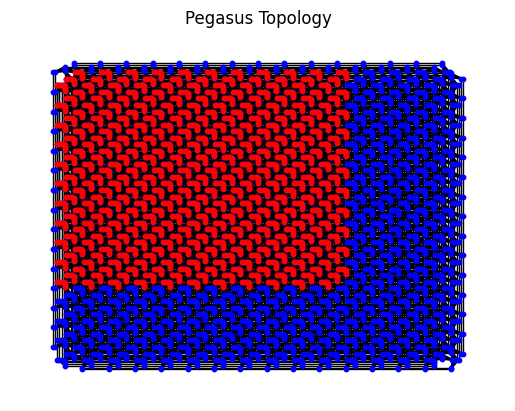

In [4]:
C16 = dnx.pegasus_graph(16)
pos = dnx.pegasus_layout(C16)
coords = dnx.pegasus_coordinates(16)

#Identify individual cell
nodes_cell=subgraph(10) #cell(1,0)

A = dnx.pegasus_graph(16, node_list=nodes_cell)
posA =  dnx.pegasus_layout(A)

fig, ax = plt.subplots()
nx.draw(C16, pos, with_labels=False, node_size=10, font_size=4, linewidths=1, node_color='blue', font_color='black', font_weight='bold')
nx.draw(A, posA, node_size=10, font_size=4, linewidths=1, node_color='red')
plt.title('Pegasus Topology')
plt.show()

#### Generate a SAT problem given a subgraph

In [8]:
def couples_subgraph(qubits):
    qubit_indices = DWaveSampler().nodelist
    adjacency = DWaveSampler().adjacency
    
    #List of all couples
    couple=[]
    qubit_valid=[]
    for q in qubits:
        if q in adjacency:
            qubit_valid.append(q)
            for c in adjacency[q]:
                if c in qubits and ((q,c) or (c,q)) not in couple:
                    couple.append((q,c))
    
    return couple

In [9]:
def generate_sat(couple, p):
    SAT=""
    num_clauses=0
    var=[]
    for coupler in couple:
        if random.uniform(0.0,1.0)>=p:
            SAT += ("1 " + str(random.choice([coupler[0], -coupler[0]])) + " " + str(random.choice([coupler[1], -coupler[1]])) + " 0\n")
            num_clauses+=1
            if coupler[0] not in var:
                var.append(coupler[0])
            if coupler[1] not in var:
                var.append(coupler[1])
    
    return SAT, len(var), num_clauses

#### Generate all the problems

In [10]:
p=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for subgraph_index in range(15):
    couples = couples_subgraph(subgraph(subgraph_index))
    for probability in p:
        subgraph_directory = f"Problems/Subgraph_{subgraph_index}"
        probability_directory = f"{subgraph_directory}/Probability_{probability}"
        # Create directories if they don't exist
        os.makedirs(subgraph_directory, exist_ok=True)
        os.makedirs(probability_directory, exist_ok=True)
        
        for iter in range(100):
            SAT, num_var, num_clauses = generate_sat(couples, probability)
            file_name = "Problems/Subgraph_"+str(subgraph_index)+"/Probability_"+str(probability)+"/Problem_"+str(iter)+"_subgraph_"+str(subgraph_index)+"_p_"+str(probability)+".wcnf"
            header="c SAT problem\np wcnf "+str(num_var)+" "+str(num_clauses)+"\n"
            with open(file_name, 'w') as archivo:
                archivo.write(header)
                archivo.write(SAT)

## Solving

#### Create a list with the clauses

In [11]:
def parsear_cnf(file_name):
    clauses=[]
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.startswith('c') and not line.startswith('p'):
                clauses.append(list(map(int, line.split()[1:-1])))
    return clauses

#### Generate ising hamiltonian from a SAT file (wcnf)

In [12]:
def find_h_J(clauses):
    h={}
    J={}
    qubits=[]
    couple=[]
    for clause in clauses:
        if np.abs(clause[0]) not in qubits:
            h[np.abs(clause[0])] = (0.25 if clause[0]<0 else -0.25)
            qubits.append(np.abs(clause[0]))
        else:
            h[np.abs(clause[0])] += (0.25 if clause[0]<0 else -0.25)
        if np.abs(clause[1]) not in qubits:
            h[np.abs(clause[1])] = (0.25 if clause[1]<0 else -0.25)
            qubits.append(np.abs(clause[1]))
        else:
            h[np.abs(clause[1])] += (0.25 if clause[1]<0 else -0.25)
        if [np.abs(clause[0]),np.abs(clause[1])] not in couple:
            J[np.abs(clause[0]),np.abs(clause[1])] = (0.25 if clause[0]*clause[1]>0 else -0.25)
            couple.append([clause[0],clause[1]])
        else:
            J[np.abs(clause[0]),np.abs(clause[1])] += (0.25 if clause[0]*clause[1]>0 else -0.25)

    return h, J, qubits

#### Count unsatisfied clauses

In [13]:
def count_unsatisfied_clauses(assignment, clauses):
    count = 0
    for clause in clauses:
        for literal in clause:
            if (literal > 0 and assignment[literal] == 1) or (literal < 0 and assignment[-literal] == -1):
                count += 1
                break
    return str(len(clauses)-count)

#### Solve with DWave and copy the solution into a .txt

In [14]:
def solving_DWave(h,J,embedding,file_name,clauses):
    num_reads=1
    anneal_time=20.0
    sampler = FixedEmbeddingComposite(DWaveSampler(token='DEV-291d80af600d6eb433a8019c579070ba37436e9a'), embedding=embedding)
    sample_set = sampler.sample_ising(h, J, num_reads=num_reads, annealing_time=anneal_time, return_embedding=True, reduce_intersample_correlation=True)

    qpu_access_time = sample_set.info['timing']['qpu_access_time']
    #Tiempo usado por la QPU para resolver el problema de forma activa
    qpu_sampling_time = sample_set.info['timing']['qpu_sampling_time']

    file_name="DWave_solutions/DWave_"+file_name[:-4]+"txt"
    with open(file_name, 'w') as archivo:
        archivo.write("QPU access time:"+str(qpu_access_time*10**(-6))+"s."+" ; QPU sampling time:"+str(qpu_sampling_time*10**(-6))+"s.\n")
        archivo.write("o "+count_unsatisfied_clauses(sample_set.first.sample, clauses)+"\n")
        archivo.write("e "+str(sample_set.first.energy)+"\n")
        archivo.write("v "+str(sample_set.first.sample)+"\n")
        archivo.write(str(sample_set))
    return sample_set

#### Post processing D'Wave

In [16]:
def post_proces_dwave(h,J,sample_set, file_name, clauses):
    solver_greedy = SteepestDescentSolver()
    sample_set_pp = solver_greedy.sample_ising(h, J, initial_states=sample_set)
    file_name="Pp_DWave_solutions/Pp_DWave_"+file_name[:-4]+"txt"
    with open(file_name, 'w') as archivo:
        archivo.write("o "+count_unsatisfied_clauses(sample_set_pp.first.sample, clauses)+"\n")
        archivo.write("e "+str(sample_set_pp.first.energy)+"\n")
        archivo.write("v "+str(sample_set_pp.first.sample)+"\n")
        archivo.write(str(sample_set_pp))

### Solve D'Wave + Post Processing

In [ ]:
#Celda de prueba

filename=["Problems/subgraph_1_prob_0.1.wcnf","Problems/subgraph_1_prob_0.2.wcnf"]
for file in filename:
    clauses = parsear_cnf(file)
    h, J, qubits = find_h_J(clauses)
    embedding = {q: [q] for q in qubits}
    solving_DWave(h,J,embedding,file,clauses)

In [18]:
p=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for subgraph_index in range(15):
    for probability in p:
        subgraph_directory = f"Problems/Subgraph_{subgraph_index}"
        probability_directory = f"{subgraph_directory}/Probability_{probability}")
        
        for iter in range(100):
            file_name = f"Problem_{iter}_subgraph_{subgraph_index}_p_{probability}.wcnf"
            file_path = f"{probability_directory}/{file_name}"
            clauses = parsear_cnf(file_path)
            h, J, qubits = find_h_J(clauses)
            embedding = {q: [q] for q in qubits}
            sample_set = solving_DWave(h,J,embedding,file_name,clauses)
            post_proces_dwave(h,J,sample_set,file_name,clauses)

#### Solve with Simulated Annealing and copy the solution into a .txt

In [17]:
def solving_SAnnealing(h,J,file_name,clauses):
    ising_model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.Vartype.SPIN)
    sampler = neal.SimulatedAnnealingSampler()
    start_time = time.time()
    response = sampler.sample(ising_model, num_reads=100)
    end_time = time.time()
    
    file_name="SAnnealing_solutions/SAnnealing_"+file_name[9:-4]+"txt"
    with open(file_name, 'w') as archivo:
        archivo.write("Time:"+str(round(end_time-start_time, 2))+"s.\n")
        archivo.write("o "+count_unsatisfied_clauses(response.first.sample, clauses)+"\n")
        archivo.write("e "+str(response.first.energy)+"\n")
        archivo.write("v "+str(response.first.sample)+"\n")
        archivo.write(str(response))
    return response

In [19]:
def post_proces_sannealing(h,J,sample_set, file_name, clauses):
    solver_greedy = SteepestDescentSolver()
    sample_set_pp = solver_greedy.sample_ising(h, J, initial_states=sample_set)
    file_name="Pp_SAnnealing_solutions/Pp_SAnnealing_"+file_name[:-4]+"txt"
    with open(file_name, 'w') as archivo:
        archivo.write("o "+count_unsatisfied_clauses(sample_set_pp.first.sample, clauses)+"\n")
        archivo.write("e "+str(sample_set_pp.first.energy)+"\n")
        archivo.write("v "+str(sample_set_pp.first.sample)+"\n")
        archivo.write(str(sample_set_pp))

### Solve S.Annealing + Post Processing

In [ ]:
#Celda de prueba

filename=["Problems/subgraph_1_prob_0.1.wcnf","Problems/subgraph_1_prob_0.2.wcnf"]
for file in filename:
    clauses = parsear_cnf(file)
    h, J, qubits = find_h_J(clauses)
    solving_SAnnealing(h,J,file,clauses)

In [21]:
p=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for subgraph_index in range(15):
    for probability in p:
        subgraph_directory = f"Problems/Subgraph_{subgraph_index}"
        probability_directory = f"{subgraph_directory}/Probability_{probability}")
        
        for iter in range(100):
            file_name = f"Problem_{iter}_subgraph_{subgraph_index}_p_{probability}.wcnf"
            file_path = f"{probability_directory}/{file_name}"
            clauses = parsear_cnf(file_path)
            h, J, qubits = find_h_J(clauses)
            embedding = {q: [q] for q in qubits}
            sample_set = solving_SAnnealing(h,J,file_name,clauses)
            post_proces_sannealing(h,J,sample_set,file_name,clauses)